# comparing models behavior with participants behavior

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ["OMP_NUM_THREADS"] = "1"
import seaborn as sns 
import ast
from scipy.stats import pearsonr
from statsmodels.stats.multitest import fdrcorrection

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.stats import pearsonr
from statsmodels.stats.multitest import fdrcorrection
import warnings
warnings.filterwarnings("ignore")

In [2]:
output_dir = r"15_RL_agent_TDlearn_output_behavior_softmax"
os.makedirs(output_dir, exist_ok=True)


folder_path_participants = 'data_risk_added'
folder_path_colors = '11_RL_agent_TDlearn_output_softmax/model_behavior'
folder_path_numbers = '12_RL_agent_TDlearn_output_softmax/model_behavior'
folder_path_colors_numbers = '13_RL_agent_TDlearn_output_softmax/model_behavior'


df_participants = []
df_colors = []
df_numbers = []
df_colors_numbers = []


def find_matching_csv(folder_path, df_list):
            for csv_file in os.listdir(folder_path):
                if clean_name in csv_file and csv_file.endswith('.csv'):
                    csv_path = os.path.join(folder_path, csv_file)
                    df_csv = pd.read_csv(csv_path)
                    df_list.append(df_csv)





for file_name in os.listdir(folder_path_participants):
    if file_name.endswith('.xlsx'):
        file_path = os.path.join(folder_path_participants, file_name)
        df = pd.read_excel(file_path)
        df = df[df['outcome'].str.lower() != 'na'].reset_index(drop=True)  
        df_participants.append(df)

        clean_name = file_name.removeprefix("task_data_").removesuffix(".xlsx")


        find_matching_csv(folder_path_colors, df_colors)
        find_matching_csv(folder_path_numbers, df_numbers)
        find_matching_csv(folder_path_colors_numbers, df_colors_numbers)


In [3]:
df_participants[2].head(5)

,arrowRT,distribution,interTrialInterval,outcome,myCard,yourCard,spaceRT,totalReward,trialIndex,trialType,choice,block,timeoutRepeat,is_within_IQR,risk
0,2609,uniform,789,lose,4,2,335,9.5,0,response,arrowdown,1,0,1,0.375
1,597,uniform,853,win,9,4,407,10,1,response,arrowup,1,0,1,0.000
2,188,uniform,904,win,4,7,504,10.5,2,response,arrowdown,1,0,1,0.375
3,423,uniform,916,win,2,4,434,11,3,response,arrowdown,1,0,1,0.125
4,549,uniform,806,win,5,7,287,11.5,4,response,arrowdown,1,0,1,0.500


In [4]:
df_colors[2].head(5)

,model_choices,participant_choices,model_total_reward,participant_total_reward,q_val
0,1,0,9.5,10.5,"[[0.4553656492041278, 0.017228503202055424], [..."
1,0,0,9.0,10.0,"[[-0.41169218435417543, 0.017228503202055424],..."
2,0,1,8.5,10.5,"[[-0.41169218435417543, 0.4553757282629882], [..."
3,0,1,8.0,11.0,"[[-0.41169218435417543, 0.4958752212148678], [..."
4,1,1,8.5,11.5,"[[-0.41169218435417543, 0.4996187321526154], [..."


In [5]:
df_numbers[2].head()

,model_choices,participant_choices,model_total_reward,participant_total_reward,q_val
0,1,0,9.5,10.5,"[[-0.005781484717304979, -0.000360978904806554..."
1,0,0,9.0,10.0,"[[-0.005781484717304979, -0.000360978904806554..."
2,1,1,9.5,10.5,"[[-0.005781484717304979, -0.000360978904806554..."
3,0,1,9.0,11.0,"[[-0.005781484717304979, -0.000360978904806554..."
4,0,1,8.5,11.5,"[[-0.005781484717304979, -0.000360978904806554..."


In [6]:
df_colors_numbers[2].head(5)

,model_choices,participant_choices,model_total_reward,participant_total_reward,q_val
0,1,0,10.5,9.5,"[[[0.04967141530112327, -0.013826430117118467]..."
1,0,1,10.0,10.0,"[[[0.04967141530112327, -0.013826430117118467]..."
2,0,0,10.5,10.5,"[[[0.04967141530112327, -0.013826430117118467]..."
3,0,0,11.0,11.0,"[[[0.04967141530112327, -0.013826430117118467]..."
4,0,0,11.5,11.5,"[[[0.04967141530112327, -0.013826430117118467]..."


# COLOR abs(delta q values) correlatation with spaceRT and arrowRT

In [7]:
distributions_map = {"uniform": 0, "low": 1, "high": 2}
actions = {"arrowdown": 0, "arrowup": 1}

spaceRT_participants = []
arrowRT_participants = []

delta_q_val_uniform = []
delta_q_val_low = []
delta_q_val_high = []

for df in df_participants:
    spaceRT_normalized = np.array(df['spaceRT'], dtype=float) / np.mean(df['spaceRT'])
    spaceRT_participants.append(spaceRT_normalized)

    arrowRT_normalized = np.array(df['arrowRT'], dtype=float) / np.mean(df['arrowRT'])
    arrowRT_participants.append(arrowRT_normalized)

for df in df_colors:    
    delta_uniform, delta_low, delta_high = [], [], []
    temp_df = df['q_val']

    for q_vals in temp_df:
        temp_vec2 = np.array(ast.literal_eval(q_vals)) 
        delta = temp_vec2[:, actions["arrowup"]] - temp_vec2[:, actions["arrowdown"]]
        delta_uniform.append(delta[distributions_map["uniform"]])
        delta_low.append(delta[distributions_map["low"]])
        delta_high.append(delta[distributions_map["high"]])

    delta_q_val_uniform.append(delta_uniform)
    delta_q_val_low.append(delta_low)
    delta_q_val_high.append(delta_high)


In [8]:
spaceRT_participants = np.array(spaceRT_participants)
arrowRT_participants = np.array(arrowRT_participants)

# importannnttt: it's important that you find the abs value of delta q values
delta_q_val_uniform = np.array(np.abs(delta_q_val_uniform))
delta_q_val_low = np.array(np.abs(delta_q_val_low))
delta_q_val_high = np.array(np.abs(delta_q_val_high))

num_participants = spaceRT_participants.shape[0]

correlations_spaceRT = np.zeros((num_participants, 3))
correlations_arrowRT = np.zeros((num_participants, 3))
p_values_spaceRT = np.zeros((num_participants, 3))
p_values_arrowRT = np.zeros((num_participants, 3))

xticklabels = [f'p{i+1}' for i in range(num_participants)]
yticklabels = ['uniform', 'low', 'high']

# for i in range(num_participants):
#     for j, delta_q_val in enumerate([delta_q_val_uniform, delta_q_val_low, delta_q_val_high]):
#         corr, p_val = pearsonr(spaceRT_participants[i, :], delta_q_val[i, :])
#         correlations_spaceRT[i, j] = corr
#         p_values_spaceRT[i, j] = p_val

#         corr, p_val = pearsonr(arrowRT_participants[i, :], delta_q_val[i, :])
#         correlations_arrowRT[i, j] = corr
#         p_values_arrowRT[i, j] = p_val

# ####################################################################################################################
# ####################################################################################################################

# correlations_spaceRT = correlations_spaceRT.T
# correlations_arrowRT = correlations_arrowRT.T
# p_values_spaceRT = p_values_spaceRT.T
# p_values_arrowRT = p_values_arrowRT.T

# annot_spaceRT = np.array([["*" if p_values_spaceRT[j, i] < 0.05 else "" 
#                             for i in range(num_participants)] for j in range(3)])
# annot_arrowRT = np.array([["*" if p_values_arrowRT[j, i] < 0.05 else "" 
#                             for i in range(num_participants)] for j in range(3)])



# fig, axes = plt.subplots(2, 1, figsize=(20, 5), gridspec_kw={'hspace': 0.8})



# sns.heatmap(correlations_spaceRT, cmap='coolwarm', linewidths=0.5,
#             xticklabels=xticklabels, yticklabels=yticklabels,
#             cbar=True, vmin=-0.4, vmax=0.4, ax=axes[0],
#             cbar_kws={'pad': 0.02}, annot=annot_spaceRT, fmt='')
# axes[0].set_title("spaceRT", fontsize=14, fontweight='bold')

# sns.heatmap(correlations_arrowRT, cmap='coolwarm', linewidths=0.5,
#             xticklabels=xticklabels, yticklabels=yticklabels,
#             cbar=True, vmin=-0.4, vmax=0.4, ax=axes[1],
#             cbar_kws={'pad': 0.02}, annot=annot_arrowRT, fmt='')
# axes[1].set_title("arrowRT", fontsize=14, fontweight='bold')

# fig.suptitle('Δq-values [q(up)-q(down)] and RTs correlations', fontsize=16, fontweight='bold', y=0.99)


# plt.tight_layout(rect=[0, 0, 1, 1])

# filename = os.path.join(output_dir, "correlation_qVal_arrowRT_colors.pdf")
# plt.savefig(filename, format='pdf')

# # plt.close()


# clustering

In [9]:

# correlations_stacked = correlations_arrowRT.reshape(num_participants, -1)  
# data = correlations_stacked

# # Perform PCA to reduce dimensions to 2D
# pca = PCA(n_components=2)
# data_2d = pca.fit_transform(data)

# # Determine the optimal number of clusters using the elbow method and silhouette score
# inertia = []
# silhouette_scores = []
# k_range = range(2, 10)  # clusters from 2 to 9

# for k in k_range:
#     kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
#     labels = kmeans.fit_predict(data_2d)
#     inertia.append(kmeans.inertia_)
#     silhouette_scores.append(silhouette_score(data_2d, labels))

# # Select the best k using the silhouette score
# best_k = k_range[np.argmax(silhouette_scores)]

# # Apply k-means clustering with the best k
# kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
# labels = kmeans.fit_predict(data_2d)

# # Plot the results
# fig, axes = plt.subplots(1, 3, figsize=(13, 4))

# # elbow method plot
# axes[0].plot(k_range, inertia, marker='o', linestyle='-', color='gray')
# axes[0].set_xlabel('number of clusters')
# axes[0].set_ylabel('within-cluster sum of squares')
# axes[0].set_title('elbow method')
# axes[0].spines['top'].set_visible(False)
# axes[0].spines['right'].set_visible(False)

# # silhouette score plot
# axes[1].plot(k_range, silhouette_scores, marker='o', linestyle='-', color='gray')
# axes[1].set_xlabel('number of clusters')
# axes[1].set_ylabel('silhouette score')
# axes[1].set_title('silhouette score')
# axes[1].spines['top'].set_visible(False)
# axes[1].spines['right'].set_visible(False)

# # k-means clustering scatter plot
# scatter = axes[2].scatter(data_2d[:, 0], data_2d[:, 1], c=labels, cmap=plt.cm.Pastel1)
# axes[2].set_xlabel('PCA component 1')
# axes[2].set_ylabel('PCA component 2')
# axes[2].set_title(f'k-means clustering (k={best_k})')
# axes[2].spines['top'].set_visible(False)
# axes[2].spines['right'].set_visible(False)

# # annotate points with participant indices
# for i, (x, y) in enumerate(data_2d):
#     axes[2].text(x, y, str(i), fontsize=8, fontweight='bold', ha='center', va='center', color='black')

# # save the figure
# filename = os.path.join(output_dir, "correlations_deltaQval_arrowRT_clustering_colors.pdf")
# plt.savefig(filename, format='pdf')

# plt.show()


# NUMBERS abs(delta q values) correlatation with spaceRT and arrowRT 

In [10]:
# delta_q_val_1 = []
# delta_q_val_2 = []
# delta_q_val_3 = []
# delta_q_val_4 = []
# delta_q_val_5 = []
# delta_q_val_6 = []
# delta_q_val_7 = []
# delta_q_val_8 = []
# delta_q_val_9 = []

# for df in df_numbers:
    
#     delta_1 = []
#     delta_2 = []
#     delta_3 = []
#     delta_4 = []
#     delta_5 = []
#     delta_6 = []
#     delta_7 = []
#     delta_8 = []
#     delta_9 = []
    
#     temp_df = df['q_val']
#     for q_vals in temp_df:
        
#         temp_vec2 = np.array(ast.literal_eval(q_vals)) 
#         delta = temp_vec2[:, actions["arrowup"]] - temp_vec2[:, actions["arrowdown"]]
#         delta_1.append(delta[0])
#         delta_2.append(delta[1])
#         delta_3.append(delta[2])
#         delta_4.append(delta[3])
#         delta_5.append(delta[4])
#         delta_6.append(delta[5])
#         delta_7.append(delta[6])
#         delta_8.append(delta[7])
#         delta_9.append(delta[8])
        
        

#     delta_q_val_1.append(delta_1)
#     delta_q_val_2.append(delta_2)
#     delta_q_val_3.append(delta_3)
#     delta_q_val_4.append(delta_4)
#     delta_q_val_5.append(delta_5)
#     delta_q_val_6.append(delta_6)
#     delta_q_val_7.append(delta_7)
#     delta_q_val_8.append(delta_8)
#     delta_q_val_9.append(delta_9)
        
    


In [11]:
# # delta_q_val_1 = np.array(delta_q_val_1)
# # delta_q_val_2 = np.array(delta_q_val_2)
# # delta_q_val_3 = np.array(delta_q_val_3)
# # delta_q_val_4 = np.array(delta_q_val_4)
# # delta_q_val_5 = np.array(delta_q_val_5)
# # delta_q_val_6 = np.array(delta_q_val_6)
# # delta_q_val_7 = np.array(delta_q_val_7)
# # delta_q_val_8 = np.array(delta_q_val_8)
# # delta_q_val_9 = np.array(delta_q_val_9)

# delta_q_val_1 = np.array(np.abs(delta_q_val_1))
# delta_q_val_2 = np.array(np.abs(delta_q_val_2))
# delta_q_val_3 = np.array(np.abs(delta_q_val_3))
# delta_q_val_4 = np.array(np.abs(delta_q_val_4))
# delta_q_val_5 = np.array(np.abs(delta_q_val_5))
# delta_q_val_6 = np.array(np.abs(delta_q_val_6))
# delta_q_val_7 = np.array(np.abs(delta_q_val_7))
# delta_q_val_8 = np.array(np.abs(delta_q_val_8))
# delta_q_val_9 = np.array(np.abs(delta_q_val_9))

# # ─────────────────────────────────────────────────────────────────────────
# # 1) Compute correlations for spaceRT
# # ─────────────────────────────────────────────────────────────────────────
# # correlations_numbers_space = np.zeros((num_participants, 9))
# # correlations_numbers_pval_space = np.zeros((num_participants, 9))

# # for i in range(num_participants):
# #     corr, pval = pearsonr(spaceRT_participants[i, :], delta_q_val_1[i, :])
# #     correlations_numbers_space[i, 0] = corr
# #     correlations_numbers_pval_space[i, 0] = pval

# #     corr, pval = pearsonr(spaceRT_participants[i, :], delta_q_val_2[i, :])
# #     correlations_numbers_space[i, 1] = corr
# #     correlations_numbers_pval_space[i, 1] = pval

# #     corr, pval = pearsonr(spaceRT_participants[i, :], delta_q_val_3[i, :])
# #     correlations_numbers_space[i, 2] = corr
# #     correlations_numbers_pval_space[i, 2] = pval

# #     corr, pval = pearsonr(spaceRT_participants[i, :], delta_q_val_4[i, :])
# #     correlations_numbers_space[i, 3] = corr
# #     correlations_numbers_pval_space[i, 3] = pval

# #     corr, pval = pearsonr(spaceRT_participants[i, :], delta_q_val_5[i, :])
# #     correlations_numbers_space[i, 4] = corr
# #     correlations_numbers_pval_space[i, 4] = pval

# #     corr, pval = pearsonr(spaceRT_participants[i, :], delta_q_val_6[i, :])
# #     correlations_numbers_space[i, 5] = corr
# #     correlations_numbers_pval_space[i, 5] = pval

# #     corr, pval = pearsonr(spaceRT_participants[i, :], delta_q_val_7[i, :])
# #     correlations_numbers_space[i, 6] = corr
# #     correlations_numbers_pval_space[i, 6] = pval

# #     corr, pval = pearsonr(spaceRT_participants[i, :], delta_q_val_8[i, :])
# #     correlations_numbers_space[i, 7] = corr
# #     correlations_numbers_pval_space[i, 7] = pval

# #     corr, pval = pearsonr(spaceRT_participants[i, :], delta_q_val_9[i, :])
# #     correlations_numbers_space[i, 8] = corr
# #     correlations_numbers_pval_space[i, 8] = pval



# # correlations_numbers_space = correlations_numbers_space.T
# # correlations_numbers_pval_space = correlations_numbers_pval_space.T



# # annots_space = np.array([
# #     ["*" if correlations_numbers_pval_space[row, col] < 0.05 else "" 
# #      for col in range(num_participants)]
# #     for row in range(9)
# # ])

# # ─────────────────────────────────────────────────────────────────────────
# # 2) Compute correlations for arrowRT
# # ─────────────────────────────────────────────────────────────────────────
# correlations_numbers_arrow = np.zeros((num_participants, 9))
# correlations_numbers_pval_arrow = np.zeros((num_participants, 9))

# for i in range(num_participants):
#     corr, pval = pearsonr(arrowRT_participants[i, :], delta_q_val_1[i, :])
#     correlations_numbers_arrow[i, 0] = corr
#     correlations_numbers_pval_arrow[i, 0] = pval

#     corr, pval = pearsonr(arrowRT_participants[i, :], delta_q_val_2[i, :])
#     correlations_numbers_arrow[i, 1] = corr
#     correlations_numbers_pval_arrow[i, 1] = pval

#     corr, pval = pearsonr(arrowRT_participants[i, :], delta_q_val_3[i, :])
#     correlations_numbers_arrow[i, 2] = corr
#     correlations_numbers_pval_arrow[i, 2] = pval

#     corr, pval = pearsonr(arrowRT_participants[i, :], delta_q_val_4[i, :])
#     correlations_numbers_arrow[i, 3] = corr
#     correlations_numbers_pval_arrow[i, 3] = pval

#     corr, pval = pearsonr(arrowRT_participants[i, :], delta_q_val_5[i, :])
#     correlations_numbers_arrow[i, 4] = corr
#     correlations_numbers_pval_arrow[i, 4] = pval

#     corr, pval = pearsonr(arrowRT_participants[i, :], delta_q_val_6[i, :])
#     correlations_numbers_arrow[i, 5] = corr
#     correlations_numbers_pval_arrow[i, 5] = pval

#     corr, pval = pearsonr(arrowRT_participants[i, :], delta_q_val_7[i, :])
#     correlations_numbers_arrow[i, 6] = corr
#     correlations_numbers_pval_arrow[i, 6] = pval

#     corr, pval = pearsonr(arrowRT_participants[i, :], delta_q_val_8[i, :])
#     correlations_numbers_arrow[i, 7] = corr
#     correlations_numbers_pval_arrow[i, 7] = pval

#     corr, pval = pearsonr(arrowRT_participants[i, :], delta_q_val_9[i, :])
#     correlations_numbers_arrow[i, 8] = corr
#     correlations_numbers_pval_arrow[i, 8] = pval


# correlations_numbers_arrow = correlations_numbers_arrow.T
# correlations_numbers_pval_arrow = correlations_numbers_pval_arrow.T


# annots_arrow = np.array([
#     ["*" if correlations_numbers_pval_arrow[row, col] < 0.05 else "" 
#      for col in range(num_participants)]
#     for row in range(9)
# ])

# # ─────────────────────────────────────────────────────────────────────────
# # 3) Plot both heatmaps in subplots
# # ─────────────────────────────────────────────────────────────────────────
# fig, axes = plt.subplots(nrows=1, figsize=(12, 3.5))


# # sns.heatmap(
# #     correlations_numbers_space,
# #     cmap='coolwarm',
# #     linewidths=0.5,
# #     xticklabels=[f'p{i+1}' for i in range(num_participants)],
# #     yticklabels=list(range(1, 10)),
# #     cbar=True,
# #     vmin=-0.4,
# #     vmax=0.4,
# #     annot=annots_space,
# #     fmt='',
# #     ax=axes[0]
# # )
# # # axes[0].set_xlabel("participants")
# # axes[0].set_ylabel("numbers")
# # axes[0].set_title("spaceRT")
# sns.heatmap(
#     correlations_numbers_arrow,
#     cmap='coolwarm',
#     linewidths=0.5,
#     xticklabels=[f'p{i+1}' for i in range(num_participants)],
#     yticklabels=list(range(1, 10)),
#     cbar=True,
#     vmin=-0.4,
#     vmax=0.4,
#     annot=annots_arrow,
#     fmt='',
#     ax=axes
# )
# axes.set_xlabel("participants")
# axes.set_ylabel("numbers")
# # axes.set_title("arrowRT")
# plt.tight_layout()
# fig.subplots_adjust(top=0.85)  # Add space between figure and title
# fig.suptitle('correlation between Δq-values [q(up)-q(down)] and arrowRT', 
#              fontsize=16, fontweight='bold', y=0.99)

# filename = os.path.join(output_dir, "correlation_qVal_arrowRT_numbers.pdf")
# plt.savefig(filename, format='pdf')
# # plt.close()


# clustering

In [12]:

# correlations_stacked = correlations_numbers_arrow.reshape(num_participants, -1)  
# data = correlations_stacked

# # Perform PCA to reduce dimensions to 2D
# pca = PCA(n_components=2)
# data_2d = pca.fit_transform(data)

# # Determine the optimal number of clusters using the elbow method and silhouette score
# inertia = []
# silhouette_scores = []
# k_range = range(2, 10)  # clusters from 2 to 9

# for k in k_range:
#     kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
#     labels = kmeans.fit_predict(data_2d)
#     inertia.append(kmeans.inertia_)
#     silhouette_scores.append(silhouette_score(data_2d, labels))

# # Select the best k using the silhouette score
# best_k = k_range[np.argmax(silhouette_scores)]

# # Apply k-means clustering with the best k
# kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
# labels = kmeans.fit_predict(data_2d)

# # Plot the results
# fig, axes = plt.subplots(1, 3, figsize=(13, 4))

# # elbow method plot
# axes[0].plot(k_range, inertia, marker='o', linestyle='-', color='gray')
# axes[0].set_xlabel('number of clusters')
# axes[0].set_ylabel('within-cluster sum of squares')
# axes[0].set_title('elbow method')
# axes[0].spines['top'].set_visible(False)
# axes[0].spines['right'].set_visible(False)

# # silhouette score plot
# axes[1].plot(k_range, silhouette_scores, marker='o', linestyle='-', color='gray')
# axes[1].set_xlabel('number of clusters')
# axes[1].set_ylabel('silhouette score')
# axes[1].set_title('silhouette score')
# axes[1].spines['top'].set_visible(False)
# axes[1].spines['right'].set_visible(False)

# # k-means clustering scatter plot
# scatter = axes[2].scatter(data_2d[:, 0], data_2d[:, 1], c=labels, cmap=plt.cm.Pastel1)
# axes[2].set_xlabel('PCA component 1')
# axes[2].set_ylabel('PCA component 2')
# axes[2].set_title(f'k-means clustering (k={best_k})')
# axes[2].spines['top'].set_visible(False)
# axes[2].spines['right'].set_visible(False)

# # annotate points with participant indices
# for i, (x, y) in enumerate(data_2d):
#     axes[2].text(x, y, str(i), fontsize=8, fontweight='bold', ha='center', va='center', color='black')

# # save the figure
# filename = os.path.join(output_dir, "correlations_deltaQval_arrowRT_clustering_numbers.pdf")
# plt.savefig(filename, format='pdf')

# plt.show()


# BOTH abs(delta q values) correlatation with spaceRT and arrowRT 

In [13]:

delta_q_val_1_both = []
delta_q_val_2_both = []
delta_q_val_3_both = []
delta_q_val_4_both = []
delta_q_val_5_both = []
delta_q_val_6_both = []
delta_q_val_7_both = []
delta_q_val_8_both = []
delta_q_val_9_both = []

for df in df_colors_numbers:
    

    delta_1_both = []
    delta_2_both = []
    delta_3_both = []
    delta_4_both = []
    delta_5_both = []
    delta_6_both = []
    delta_7_both = []
    delta_8_both = []
    delta_9_both = []
    
    temp_df = df['q_val']
    for q_vals in temp_df:
        
        temp_vec2 = np.array(ast.literal_eval(q_vals)) 
        delta = temp_vec2[:, :, actions["arrowup"]].squeeze() - temp_vec2[:, :, actions["arrowdown"]].squeeze()
        delta_1_both.append(delta[0][:])
        delta_2_both.append(delta[1][:])
        delta_3_both.append(delta[2][:])
        delta_4_both.append(delta[3][:])
        delta_5_both.append(delta[4][:])
        delta_6_both.append(delta[5][:])
        delta_7_both.append(delta[6][:])
        delta_8_both.append(delta[7][:])
        delta_9_both.append(delta[8][:])
        
        

    delta_q_val_1_both.append(delta_1_both)
    delta_q_val_2_both.append(delta_2_both)
    delta_q_val_3_both.append(delta_3_both)
    delta_q_val_4_both.append(delta_4_both)
    delta_q_val_5_both.append(delta_5_both)
    delta_q_val_6_both.append(delta_6_both)
    delta_q_val_7_both.append(delta_7_both)
    delta_q_val_8_both.append(delta_8_both)
    delta_q_val_9_both.append(delta_9_both)
        
    


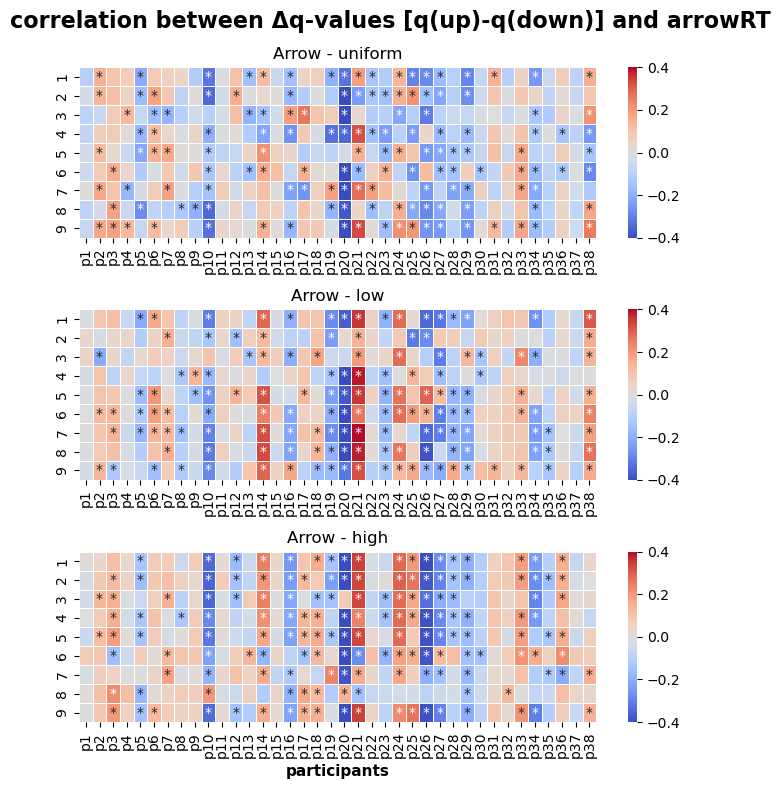

In [14]:
# delta_q_val_1_both = np.array(delta_q_val_1_both)
# delta_q_val_2_both = np.array(delta_q_val_2_both)
# delta_q_val_3_both = np.array(delta_q_val_3_both)
# delta_q_val_4_both = np.array(delta_q_val_4_both)
# delta_q_val_5_both = np.array(delta_q_val_5_both)
# delta_q_val_6_both = np.array(delta_q_val_6_both)
# delta_q_val_7_both = np.array(delta_q_val_7_both)
# delta_q_val_8_both = np.array(delta_q_val_8_both)
# delta_q_val_9_both = np.array(delta_q_val_9_both)

delta_q_val_1_both = np.abs(np.array(delta_q_val_1_both))
delta_q_val_2_both = np.abs(np.array(delta_q_val_2_both))
delta_q_val_3_both = np.abs(np.array(delta_q_val_3_both))
delta_q_val_4_both = np.abs(np.array(delta_q_val_4_both))
delta_q_val_5_both = np.abs(np.array(delta_q_val_5_both))
delta_q_val_6_both = np.abs(np.array(delta_q_val_6_both))
delta_q_val_7_both = np.abs(np.array(delta_q_val_7_both))
delta_q_val_8_both = np.abs(np.array(delta_q_val_8_both))
delta_q_val_9_both = np.abs(np.array(delta_q_val_9_both))

# Create storage for correlations and p-values for each RT type
correlations_arrow = np.zeros((num_participants, 9, len(distributions_map)))
pvals_arrow = np.zeros((num_participants, 9, len(distributions_map)))

# --- Compute Correlations (Arrow RT) ---
for i in range(num_participants):
    # number 1
    corr = np.corrcoef(arrowRT_participants[i, :],
                       delta_q_val_1_both[i, :, distributions_map["uniform"]])[0, 1]
    correlations_arrow[i, 0, distributions_map["uniform"]] = corr
    _, pval = pearsonr(arrowRT_participants[i, :],
                       delta_q_val_1_both[i, :, distributions_map["uniform"]])
    pvals_arrow[i, 0, distributions_map["uniform"]] = pval

    corr = np.corrcoef(arrowRT_participants[i, :],
                       delta_q_val_1_both[i, :, distributions_map["low"]])[0, 1]
    correlations_arrow[i, 0, distributions_map["low"]] = corr
    _, pval = pearsonr(arrowRT_participants[i, :],
                       delta_q_val_1_both[i, :, distributions_map["low"]])
    pvals_arrow[i, 0, distributions_map["low"]] = pval

    corr = np.corrcoef(arrowRT_participants[i, :],
                       delta_q_val_1_both[i, :, distributions_map["high"]])[0, 1]
    correlations_arrow[i, 0, distributions_map["high"]] = corr
    _, pval = pearsonr(arrowRT_participants[i, :],
                       delta_q_val_1_both[i, :, distributions_map["high"]])
    pvals_arrow[i, 0, distributions_map["high"]] = pval

    # Repeat for numbers 2 through 9
    for num in range(2, 10):
        delta_q_val_both = eval(f"delta_q_val_{num}_both")
        corr = np.corrcoef(arrowRT_participants[i, :],
                           delta_q_val_both[i, :, distributions_map["uniform"]])[0, 1]
        correlations_arrow[i, num - 1, distributions_map["uniform"]] = corr
        _, pval = pearsonr(arrowRT_participants[i, :],
                           delta_q_val_both[i, :, distributions_map["uniform"]])
        pvals_arrow[i, num - 1, distributions_map["uniform"]] = pval

        corr = np.corrcoef(arrowRT_participants[i, :],
                           delta_q_val_both[i, :, distributions_map["low"]])[0, 1]
        correlations_arrow[i, num - 1, distributions_map["low"]] = corr
        _, pval = pearsonr(arrowRT_participants[i, :],
                           delta_q_val_both[i, :, distributions_map["low"]])
        pvals_arrow[i, num - 1, distributions_map["low"]] = pval

        corr = np.corrcoef(arrowRT_participants[i, :],
                           delta_q_val_both[i, :, distributions_map["high"]])[0, 1]
        correlations_arrow[i, num - 1, distributions_map["high"]] = corr
        _, pval = pearsonr(arrowRT_participants[i, :],
                           delta_q_val_both[i, :, distributions_map["high"]])
        pvals_arrow[i, num - 1, distributions_map["high"]] = pval

# ----------------------------------------------------------
# ----------------------------------------------------------
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(7, 8))  # 3x1 layout
labels = ['uniform', 'low', 'high']

for row_idx, dist_label in enumerate(labels):
    # ARROW
    ax_arrow = axes[row_idx]
    data_arrow = correlations_arrow[:, :, distributions_map[dist_label]].T

    # Make an annotation array (same shape) for significance
    annots_arrow = np.empty((9, num_participants), dtype=object)
    for r in range(9):
        for c in range(num_participants):
            if pvals_arrow[c, r, distributions_map[dist_label]] < 0.05:
                annots_arrow[r, c] = '*'
            else:
                annots_arrow[r, c] = ''

    sns.heatmap(
        data_arrow,
        ax=ax_arrow,
        cmap='coolwarm',
        linewidths=0.5,
        xticklabels=[f'p{i+1}' for i in range(num_participants)],
        yticklabels=list(range(1, 10)),
        cbar=True,
        vmin=-0.4, vmax=0.4,
        annot=annots_arrow, fmt=""
    )
    ax_arrow.set_title(f"Arrow - {dist_label}")
    if row_idx == 2:
        ax_arrow.set_xlabel("participants", fontsize=11, fontweight='bold')

fig.suptitle('correlation between Δq-values [q(up)-q(down)] and arrowRT', 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()

filename = os.path.join(output_dir, "correlation_qVal_arrow_RT_both.pdf")
plt.savefig(filename, format='pdf')
plt.show()


# clustering

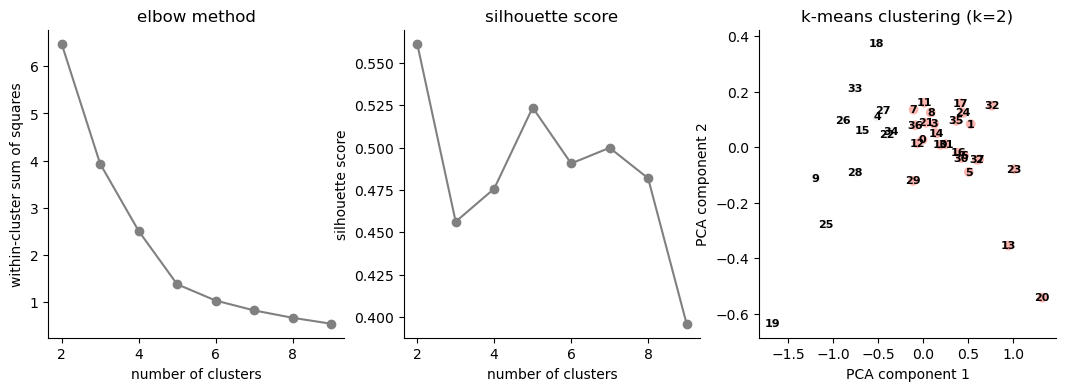

In [15]:
# Stack correlations for uniform, low, and high distributions
correlations_stacked = correlations_arrow.reshape(num_participants, -1)  # stacking 3 distributions on top of each other
data = correlations_stacked

# Perform PCA to reduce dimensions to 2D
pca = PCA(n_components=2)
data_2d = pca.fit_transform(data)

# Determine the optimal number of clusters using the elbow method and silhouette score
inertia = []
silhouette_scores = []
k_range = range(2, 10)  # clusters from 2 to 9

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(data_2d)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(data_2d, labels))

# Select the best k using the silhouette score
best_k = k_range[np.argmax(silhouette_scores)]

# Apply k-means clustering with the best k
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
labels = kmeans.fit_predict(data_2d)

# Plot the results
fig, axes = plt.subplots(1, 3, figsize=(13, 4))

# elbow method plot
axes[0].plot(k_range, inertia, marker='o', linestyle='-', color='gray')
axes[0].set_xlabel('number of clusters')
axes[0].set_ylabel('within-cluster sum of squares')
axes[0].set_title('elbow method')
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)

# silhouette score plot
axes[1].plot(k_range, silhouette_scores, marker='o', linestyle='-', color='gray')
axes[1].set_xlabel('number of clusters')
axes[1].set_ylabel('silhouette score')
axes[1].set_title('silhouette score')
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)

# k-means clustering scatter plot
scatter = axes[2].scatter(data_2d[:, 0], data_2d[:, 1], c=labels, cmap=plt.cm.Pastel1)
axes[2].set_xlabel('PCA component 1')
axes[2].set_ylabel('PCA component 2')
axes[2].set_title(f'k-means clustering (k={best_k})')
axes[2].spines['top'].set_visible(False)
axes[2].spines['right'].set_visible(False)

# annotate points with participant indices
for i, (x, y) in enumerate(data_2d):
    axes[2].text(x, y, str(i), fontsize=8, fontweight='bold', ha='center', va='center', color='black')

# save the figure
filename = os.path.join(output_dir, "correlations_deltaQval_arrowRT_clustering_both.pdf")
plt.savefig(filename, format='pdf')

plt.show()


# delta arrowRT vs risk correlations

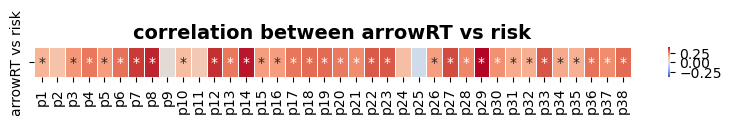

In [16]:
risk_values = []

for df in df_participants:
    risk_values.append(np.array(df['risk'], dtype=float))

risk_values = np.array(risk_values)

correlations_arrowRT_risk = np.zeros(num_participants)
p_values_arrowRT_risk = np.zeros(num_participants)

for i in range(num_participants):
    corr, p_val = pearsonr(arrowRT_participants[i, :], risk_values[i, :])
    correlations_arrowRT_risk[i] = corr
    p_values_arrowRT_risk[i] = p_val

# Create annotations for significance
annot_arrowRT_risk = np.array(["*" if p_values_arrowRT_risk[i] < 0.05 else "" for i in range(num_participants)])


fig, ax = plt.subplots(figsize=(8, 1.2))
sns.heatmap(correlations_arrowRT_risk.reshape(1, -1), cmap='coolwarm', linewidths=0.5,
            xticklabels=[f'p{i+1}' for i in range(num_participants)], yticklabels=['arrowRT vs risk'],
            cbar=True, vmin=-0.4, vmax=0.4, annot=annot_arrowRT_risk.reshape(1, -1), fmt='', ax=ax)

ax.set_title("correlation between arrowRT vs risk", fontsize=14, fontweight='bold')
# fig.suptitle('Correlation between arrowRT and risk', fontsize=16, fontweight='bold', y=1.02)

plt.tight_layout()
filename = os.path.join(output_dir, "correlation_arrowRT_risk.pdf")
plt.savefig(filename, format='pdf')
plt.show()

# delta qval vs risk correlations

In [17]:
# correlations_risk_delta_q_color = np.zeros((num_participants, 3))
# p_values_risk_delta_q_color = np.zeros((num_participants, 3))

# for i in range(num_participants):
#     for j, delta_q_val in enumerate([delta_q_val_uniform, delta_q_val_low, delta_q_val_high]):
#         corr, p_val = pearsonr(risk_values[i, :], delta_q_val[i, :])
#         correlations_risk_delta_q_color[i, j] = corr
#         p_values_risk_delta_q_color[i, j] = p_val

# # Transpose for better visualization
# correlations_risk_delta_q_color = correlations_risk_delta_q_color.T
# p_values_risk_delta_q_color = p_values_risk_delta_q_color.T

# # Create annotations for significance
# annot_risk_delta_q_color = np.array([["*" if p_values_risk_delta_q_color[j, i] < 0.05 else "" 
#                                       for i in range(num_participants)] for j in range(3)])

# # Plot the heatmap
# fig, ax = plt.subplots(figsize=(12, 2))
# sns.heatmap(correlations_risk_delta_q_color, cmap='coolwarm', linewidths=0.5,
#             xticklabels=xticklabels, yticklabels=yticklabels,
#             cbar=True, vmin=-0.4, vmax=0.4, annot=annot_risk_delta_q_color, fmt='', ax=ax)

# ax.set_title("correlation between risk and Δq-values (color model)", fontsize=14, fontweight='bold')
# plt.tight_layout()

# filename = os.path.join(output_dir, "correlation_risk_deltaQval_color.pdf")
# plt.savefig(filename, format='pdf')
# plt.show()

In [18]:
# correlations_risk_delta_q_number = np.zeros((num_participants, 9))
# p_values_risk_delta_q_number = np.zeros((num_participants, 9))

# for i in range(num_participants):
#     for j, delta_q_val in enumerate([delta_q_val_1, delta_q_val_2, delta_q_val_3, delta_q_val_4, delta_q_val_5, delta_q_val_6, delta_q_val_7, delta_q_val_8, delta_q_val_9]):
#         corr, p_val = pearsonr(risk_values[i, :], delta_q_val[i, :])
#         correlations_risk_delta_q_number[i, j] = corr
#         p_values_risk_delta_q_number[i, j] = p_val

# # Transpose for better visualization
# correlations_risk_delta_q_number = correlations_risk_delta_q_number.T
# p_values_risk_delta_q_number = p_values_risk_delta_q_number.T

# # Create annotations for significance
# annot_risk_delta_q_number = np.array([["*" if p_values_risk_delta_q_number[j, i] < 0.05 else "" 
#                                        for i in range(num_participants)] for j in range(9)])

# # Plot the heatmap
# fig, ax = plt.subplots(figsize=(12, 3))
# sns.heatmap(correlations_risk_delta_q_number, cmap='coolwarm', linewidths=0.5,
#             xticklabels=xticklabels, yticklabels=list(range(1, 10)),
#             cbar=True, vmin=-0.4, vmax=0.4, annot=annot_risk_delta_q_number, fmt='', ax=ax)

# ax.set_title("correlation between risk and Δq-values (number model)", fontsize=14, fontweight='bold')
# plt.tight_layout()

# filename = os.path.join(output_dir, "correlation_risk_deltaQval_number.pdf")
# plt.savefig(filename, format='pdf')
# plt.show()

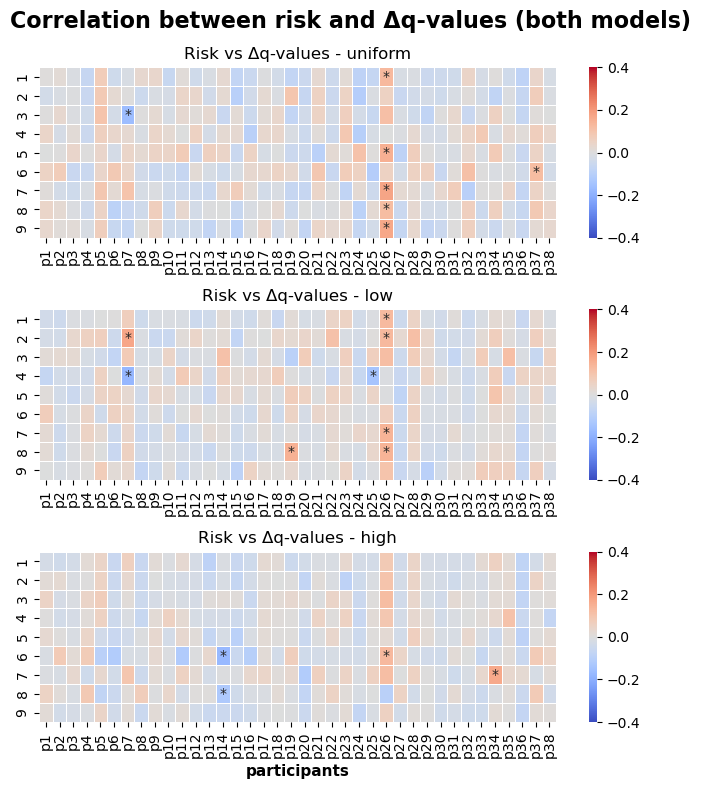

In [19]:
correlations_risk_delta_q_both = np.zeros((num_participants, 9, len(distributions_map)))
p_values_risk_delta_q_both = np.zeros((num_participants, 9, len(distributions_map)))

# Compute correlations for each participant, number, and distribution
for i in range(num_participants):
    for num in range(1, 10):  # Iterate over numbers 1 to 9
        delta_q_val_both = eval(f"delta_q_val_{num}_both")
        for dist_label, dist_idx in distributions_map.items():
            corr, p_val = pearsonr(risk_values[i, :], delta_q_val_both[i, :, dist_idx])
            correlations_risk_delta_q_both[i, num - 1, dist_idx] = corr
            p_values_risk_delta_q_both[i, num - 1, dist_idx] = p_val

# Plot the heatmaps for each distribution
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(7, 8))  # 3x1 layout
labels = ['uniform', 'low', 'high']

for row_idx, dist_label in enumerate(labels):
    ax = axes[row_idx]
    data = correlations_risk_delta_q_both[:, :, distributions_map[dist_label]].T

    # Create annotations for significance
    annots = np.empty((9, num_participants), dtype=object)
    for r in range(9):
        for c in range(num_participants):
            if p_values_risk_delta_q_both[c, r, distributions_map[dist_label]] < 0.05:
                annots[r, c] = '*'
            else:
                annots[r, c] = ''

    sns.heatmap(
        data,
        ax=ax,
        cmap='coolwarm',
        linewidths=0.5,
        xticklabels=xticklabels,
        yticklabels=list(range(1, 10)),
        cbar=True,
        vmin=-0.4, vmax=0.4,
        annot=annots, fmt=""
    )
    ax.set_title(f"Risk vs Δq-values - {dist_label}")
    if row_idx == 2:
        ax.set_xlabel("participants", fontsize=11, fontweight='bold')

fig.suptitle('Correlation between risk and Δq-values (both models)', 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()

filename = os.path.join(output_dir, "correlation_risk_deltaQval_both.pdf")
plt.savefig(filename, format='pdf')
plt.show()